# Denoising Diffusion Probabilistic Models (DDPM)

* https://arxiv.org/abs/2006.11239

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2

from livelossplot import PlotLosses
from livelossplot.outputs.matplotlib_plot import MatplotlibPlot
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

## Dataset

In [2]:
image_size = 24
image_channels = 1

dataset = MNIST(
    root='../data',
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_size),
        v2.ToDtype(torch.float32, scale=True),  # [0, 255] -> [0, 1]
        v2.Lambda(lambda x: x * 2 - 1),         # [0, 1] -> [-1, 1]
    ]),
)

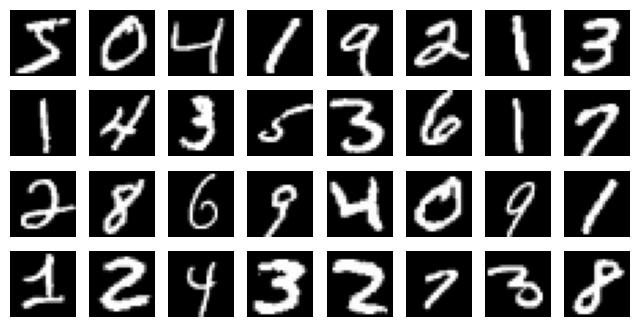

In [3]:
def to_image(x):
    x = x.clamp(-1, 1) * 0.5 + 0.5
    x = x.detach().cpu()
    return v2.functional.to_pil_image(x)

def plot_images(images, ncols=8):
    nrows = (len(images) - 1) // ncols + 1
    plt.figure(figsize=(ncols, nrows))
    for i, x in enumerate(images):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(x, cmap='gray')
        plt.axis('off')
    plt.show()

plot_images([to_image(dataset[i][0]) for i in range(32)])

## Model

In [4]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, dim=32, T=10000):
        super().__init__()
        half_dim = dim // 2
        i = torch.arange(half_dim)
        denom = torch.exp(-(i / half_dim) * np.log(T))
        denom = denom.unsqueeze(0)          # (1, dim/2)
        pos = torch.arange(T).unsqueeze(1)  # (T, 1)
        emb = torch.zeros(T, dim)           # (T, dim)
        emb[:, 0::2] = torch.sin(pos * denom)
        emb[:, 1::2] = torch.cos(pos * denom)
        self.register_buffer('emb', emb)

    def forward(self, x):
        return self.emb[x]

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embedding_dim=32):
        super().__init__()
        self.embedding = nn.Sequential(
            SinusoidalPositionalEmbedding(embedding_dim),
            nn.Linear(embedding_dim, out_channels),
        )
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, t):
        batch_size = x.shape[0]
        embedding = self.embedding(t).view(batch_size, -1, 1, 1)
        x = self.conv1(x)
        residual = self.conv2(x + embedding)
        return x + residual


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ResBlock(image_channels, 64),
            ResBlock(64, 128),
        )
        self.bottom = ResBlock(128, 256)
        self.decoder = nn.Sequential(
            ResBlock(256 + 128, 128),
            ResBlock(128 + 64, 64),
        )
        self.head = nn.Conv2d(64, image_channels, kernel_size=1)
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, t):
        skips = []
        for block in self.encoder:
            x = block(x, t)
            skips.append(x)
            x = self.downsample(x)
        x = self.bottom(x, t)
        for block in self.decoder:
            x = self.upsample(x)
            skip = skips.pop()
            x = block(torch.cat([x, skip], dim=1), t)
        return self.head(x)

In [6]:
class DDPM(nn.Module):
    def __init__(self, T=1000, min_beta=1e-4, max_beta=0.02):
        super().__init__()
        self.unet = UNet()
        self.T = T

        beta = torch.linspace(min_beta, max_beta, T).view(-1, 1, 1, 1)
        alpha = 1. - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        alpha_bar_prev = torch.cat([torch.ones_like(alpha_bar[0:1]), alpha_bar[:-1]], dim=0)

        self.register_buffer('beta', beta)
        self.register_buffer('sqrt_alpha_bar', torch.sqrt(alpha_bar))
        self.register_buffer('sqrt_one_minus_alpha_bar', torch.sqrt(1 - alpha_bar))
        self.register_buffer('sqrt_recip_alpha', torch.sqrt(1. / alpha))
        self.register_buffer('sqrt_recip_one_minus_alpha_bar', 1. / self.sqrt_one_minus_alpha_bar)
        posterior_variance = beta * (1. - alpha_bar_prev) / (1. - alpha_bar)
        self.register_buffer('posterior_log_variance', torch.log(posterior_variance))

    @property
    def device(self):
        return next(self.parameters()).device

    def diffuse(self, x0, t):
        e = torch.randn_like(x0, device=x0.device)
        xt = self.sqrt_alpha_bar[t] * x0 + self.sqrt_one_minus_alpha_bar[t] * e
        return xt, e

    def compute_loss(self, x0):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.T, (batch_size,), device=x0.device)  # 0-based
        xt, e = self.diffuse(x0, t)
        e_pred = self.unet(xt, t)
        return F.mse_loss(e_pred, e)

    def denoise(self, xt, t):
        with torch.inference_mode():
            e_pred = self.unet(xt, t)

        mean = self.sqrt_recip_alpha[t] * (xt - self.beta[t] * self.sqrt_recip_one_minus_alpha_bar[t] * e_pred)
        logvar = self.posterior_log_variance[t]

        noise = torch.randn_like(xt, device=xt.device)
        noise[t == 0] = 0
        return mean + (0.5 * logvar).exp() * noise

    def sample(self, n=32):
        x = torch.randn(n, image_channels, image_size, image_size, device=self.device)
        for i in tqdm(reversed(range(0, self.T)), total=self.T):
            t = torch.tensor([i] * n, device=self.device)
            x = self.denoise(x, t)
        return [to_image(x[i]) for i in range(n)]

## Training

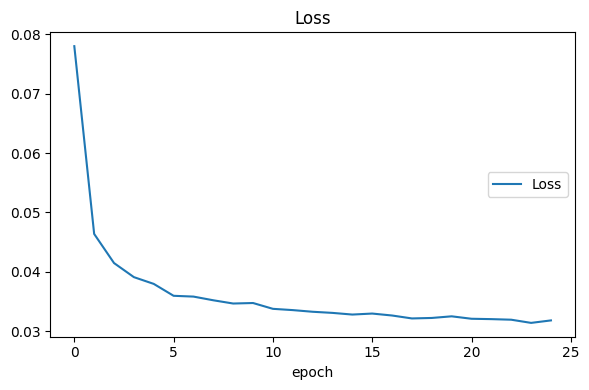

In [7]:
epochs = 25
batch_size = 128
learning_rate = 4e-4

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model = DDPM().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train()
logs = PlotLosses(outputs=[MatplotlibPlot(max_cols=1)], figsize=(6, 4))
for epoch in range(epochs):
    losses = []
    for x, _ in dataloader:
        x = x.to(device)

        optimizer.zero_grad()
        loss = model.compute_loss(x)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    logs.update({'Loss': np.mean(losses)})
    logs.send()

## Sampling

  0%|          | 0/1000 [00:00<?, ?it/s]

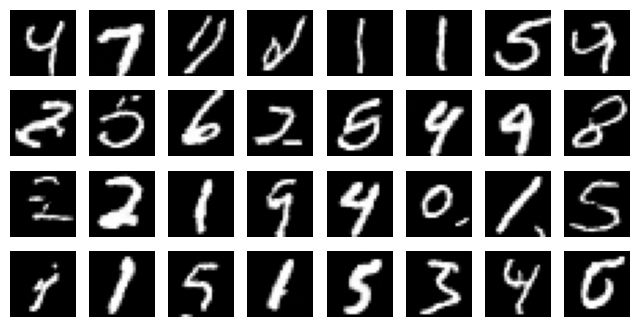

In [8]:
model.eval()
images = model.sample(32)
plot_images(images)